In [1]:
pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from IPython.display import display
import re

In [3]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [4]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model = model.to(device)

In [6]:
def show_image(pathStr):
    img = Image.open(pathStr).convert("RGB")
    display(img)

In [7]:
from PIL import Image

def TrOCR_image(path):
    # Load the image
    image = Image.open(path).convert("RGB")

    # Process the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    
    # Generate OCR output
    pixel_values = pixel_values.to(device)
    generated_ids = model.generate(pixel_values, num_beams=5)
    
    ocr_output = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Remove non-alphanumeric characters and replace multiple spaces with a single space
    ocr_output_cleaned = re.sub(r'[^a-zA-Z0-9\s\'-]', ' ', ocr_output)
    ocr_output_cleaned = ' '.join(ocr_output_cleaned.split())

    # Remove hyphens surrounded by spaces
    ocr_output_cleaned = re.sub(r'\s-\s', ' ', ocr_output_cleaned)

    return ocr_output_cleaned

In [9]:
import os
import pandas as pd

# Load the CSV file
csv_path = '../data/raw/test_data.csv' 
df = pd.read_csv(csv_path)

# Path to the folder with images
image_folder = '../data/raw/test_data' 
original_texts = []
predicted_texts = []

# Iterate through each row in the dataframe
for index, row in df.iterrows():
    if index%5==0:
        print(index)
    image_name = row['image_name.jpg']
    image_path = os.path.join(image_folder, image_name)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Get the actual text from the CSV
        actual_text = row['text']

        # Run TrOCR_image on the image
        predicted_text = TrOCR_image(image_path)

        # Append to the lists
        original_texts.append(actual_text)
        predicted_texts.append(predicted_text)
    else:
        print(f"Image not found: {image_name}")

# Print or use the lists as needed
print("Original Texts:")
for text in original_texts[:50]:
    print(text)

# Print the first 5 elements from predicted_texts
print("\nPredicted Texts:")
for text in predicted_texts[:50]:
    print(text)

0


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
Original Texts:
Imagine a vast sheet of paper on which straight
Lines Triangles Squares Pentagons Hexagons and other
figures instead of remaining fixed in their places
move freely about on or in the surface but without
the p

In [10]:
def character_error_rate(original_texts, predicted_texts):
    total_distance = 0
    total_chars = 0

    for original_text, predicted_text in zip(original_texts, predicted_texts):
        original_chars = list(str(original_text).lower())
        predicted_chars = list(predicted_text.lower())

        # Calculate Levenshtein distance for each pair of texts
        if len(original_chars) < len(predicted_chars):
            original_chars, predicted_chars = predicted_chars, original_chars

        if len(predicted_chars) == 0:
            lev_distance = len(original_chars)
        else:
            previous_row = range(len(predicted_chars) + 1)

            for i, c1 in enumerate(original_chars):
                current_row = [i + 1]

                for j, c2 in enumerate(predicted_chars):
                    insertions = previous_row[j + 1] + 1
                    deletions = current_row[j] + 1
                    substitutions = previous_row[j] + (c1 != c2)

                    current_row.append(min(insertions, deletions, substitutions))

                previous_row = current_row

            lev_distance = previous_row[-1]

        # Update total distance and character count
        total_distance += lev_distance
        total_chars += len(original_chars)

    # Calculate overall CER
    cer = (total_distance / total_chars) * 100

    # Avoid division by zero
    if total_chars == 0:
        return 0.0

    return cer

cer = character_error_rate(original_texts, predicted_texts)

print(f"Character Error Rate: {cer}%")

Character Error Rate: 7.073027886651349%


In [11]:
for i,k in zip(predicted_texts, original_texts):
    if isinstance(k, float):
        print(i,k)
original_texts = [str(t) for t in original_texts]

n nan


In [12]:
from torchmetrics.text import CharErrorRate
cer = CharErrorRate()
cer(predicted_texts[900:], original_texts[900:])

tensor(0.1219)

In [13]:
def calculate_wer(original_texts, predicted_texts):
    total_substitutions = 0
    total_deletions = 0
    total_insertions = 0
    total_words = 0

    for original_text, predicted_text in zip(original_texts, predicted_texts):
        ref_words =str(original_text).split()
        hyp_words =str(predicted_text).split()

        substitutions = sum(1 for ref, hyp in zip(ref_words, hyp_words) if ref != hyp)
        deletions = len(ref_words) - len(hyp_words)
        insertions = len(hyp_words) - len(ref_words)

        total_substitutions += substitutions
        total_deletions += deletions
        total_insertions += insertions
        total_words += len(ref_words)

    # Avoid division by zero
    if total_words == 0:
        return 0.0

    wer = (total_substitutions + total_deletions + total_insertions) / total_words

    return wer

average_wer = calculate_wer(original_texts, predicted_texts)

print(f"Average Word Error Rate: {average_wer}%")

Average Word Error Rate: 0.17802469135802468%


In [14]:
import numpy as np

def calculate_wer_list(original_texts, predicted_texts):
    total_errors = 0
    total_words = 0

    for original_texts, predicted_texts in zip(original_texts, predicted_texts):
        # Split the reference and hypothesis sentences into words
        ref_words =str(original_texts).split()
        hyp_words =str(predicted_texts).split()
        # Initialize a matrix with size |ref_words|+1 x |hyp_words|+1
        # The extra row and column are for the case when one of the strings is empty
        d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))
        # The number of operations for an empty hypothesis to become the reference
        # is just the number of words in the reference (i.e., deleting all words)
        for i in range(len(ref_words) + 1):
            d[i, 0] = i
        # The number of operations for an empty reference to become the hypothesis
        # is just the number of words in the hypothesis (i.e., inserting all words)
        for j in range(len(hyp_words) + 1):
            d[0, j] = j
        # Iterate over the words in the reference and hypothesis
        for i in range(1, len(ref_words) + 1):
            for j in range(1, len(hyp_words) + 1):
                # If the current words are the same, no operation is needed
                # So we just take the previous minimum number of operations
                if ref_words[i - 1] == hyp_words[j - 1]:
                    d[i, j] = d[i - 1, j - 1]
                else:
                    # If the words are different, we consider three operations:
                    # substitution, insertion, and deletion
                    # And we take the minimum of these three possibilities
                    substitution = d[i - 1, j - 1] + 1
                    insertion = d[i, j - 1] + 1
                    deletion = d[i - 1, j] + 1
                    d[i, j] = min(substitution, insertion, deletion)
        # The minimum number of operations to transform the hypothesis into the reference
        # is in the bottom-right cell of the matrix
        # We add this to the total errors
        total_errors += d[len(ref_words), len(hyp_words)]
        total_words += len(ref_words)

    # Avoid division by zero
    if total_words == 0:
        return 0.0

    # Calculate the average WER
    wer = total_errors / total_words

    return wer

average_wer = calculate_wer_list(original_texts, predicted_texts)

print(f"Average Word Error Rate: {average_wer}%")

Average Word Error Rate: 0.16580246913580246%


In [15]:
def calculate_wer(original_texts, predicted_texts):
    wer_matrix = []

    for original_text, predicted_text in zip(original_texts, predicted_texts):
      

        original_text = str(original_text)
        predicted_text = str(predicted_text)

        ref_words = original_text.split()
        hyp_words = predicted_text.split()

        substitutions = [(ref, hyp) for ref, hyp in zip(ref_words, hyp_words) if ref.lower() != hyp.lower()]
        deletions = [(ref, None) for ref in ref_words[len(hyp_words):]]
        insertions = [(None, hyp) for hyp in hyp_words[len(ref_words):]]

        wer_matrix.append(substitutions + deletions + insertions)

    return wer_matrix

wer_matrix = calculate_wer(original_texts, predicted_texts)

print(wer_matrix)

[[('sheet', 'shell')], [('Lines', 'dines'), ('Triangles', 'Triangle'), ('Pentagons', 'Pantagons'), ('Hexagons', 'Halagous'), ('other', 'older')], [], [], [], [], [('luminous', 'business')], [('notion', 'mission')], [('Alas', 'Miss')], [], [], [("Show'd", "Show's"), ('whore', 'whole')], [('Nomacs', 'Monaco'), (None, '-')], [("brandish'd", "bandish'd")], [('Which', 'usted')], [("valour's", "colour's"), ('minion', 'minimum'), ('carved', 'served'), ('passage', 'marriage')], [], [('Triangles', 'Trangles')], [('Pentagons', 'Pentagans'), ('Hexagons', 'Heragons')], [], [('move', 'more')], [], [('rising', 'nising'), ('or', 'an')], [], [], [('notion', 'motion')], [], [], [], [('gazed', 'guard'), ('fissure', 'figure')], [], [('orb', 'arts'), ('at', 'of')], [('reeled', 'veiled')], [], [], [], [('dank', 'drank'), ('tarn', 'turn'), ('sullenly', 'suddenly')], [('silently', 'elderly')], [('fissure', 'figure'), (None, '-')], [('came', 'come'), ('whirlwind', 'whilusind')], [('orb', 'arts')], [('reeled',

In [16]:
import numpy as np

def calculate_wer_list(original_texts, predicted_texts):
    total_errors = 0
    total_words = 0

    for original_texts, predicted_texts in zip(original_texts, predicted_texts):
        # Split the reference and hypothesis sentences into words
        ref_words =str(original_texts).split()
        hyp_words =str(predicted_texts).split()
        # Initialize a matrix with size |ref_words|+1 x |hyp_words|+1
        # The extra row and column are for the case when one of the strings is empty
        d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))
        # The number of operations for an empty hypothesis to become the reference
        # is just the number of words in the reference (i.e., deleting all words)
        for i in range(len(ref_words) + 1):
            d[i, 0] = i
        # The number of operations for an empty reference to become the hypothesis
        # is just the number of words in the hypothesis (i.e., inserting all words)
        for j in range(len(hyp_words) + 1):
            d[0, j] = j
        # Iterate over the words in the reference and hypothesis
        for i in range(1, len(ref_words) + 1):
            for j in range(1, len(hyp_words) + 1):
                # If the current words are the same, no operation is needed
                # So we just take the previous minimum number of operations
                if ref_words[i - 1] == hyp_words[j - 1]:
                    d[i, j] = d[i - 1, j - 1]
                else:
                    # If the words are different, we consider three operations:
                    # substitution, insertion, and deletion
                    # And we take the minimum of these three possibilities
                    substitution = d[i - 1, j - 1] + 1
                    insertion = d[i, j - 1] + 1
                    deletion = d[i - 1, j] + 1
                    d[i, j] = min(substitution, insertion, deletion)
        # The minimum number of operations to transform the hypothesis into the reference
        # is in the bottom-right cell of the matrix
        # We add this to the total errors
        total_errors += d[len(ref_words), len(hyp_words)]
        total_words += len(ref_words)

    # Avoid division by zero
    if total_words == 0:
        return 0.0

    # Calculate the average WER
    wer = total_errors / total_words

    return wer

average_wer = calculate_wer_list(original_texts, predicted_texts)

print(f"Average Word Error Rate: {average_wer}%")

Average Word Error Rate: 0.16580246913580246%


In [17]:
def calculate_f1_char(original_text, predicted_text):
    original_chars = set(original_text.lower())
    predicted_chars = set(predicted_text.lower())

    true_positives = len(original_chars.intersection(predicted_chars))
    false_positives = len(predicted_chars - original_chars)
    false_negatives = len(original_chars - predicted_chars)

    precision_denominator = true_positives + false_positives if true_positives + false_positives != 0 else 1
    recall_denominator = true_positives + false_negatives if true_positives + false_negatives != 0 else 1

    precision = true_positives / precision_denominator
    recall = true_positives / recall_denominator

    f1_denominator = precision + recall if precision + recall != 0 else 1
    f1_score = 2 * (precision * recall) / f1_denominator

    return f1_score

def calculate_f1_list_char(original_texts, predicted_texts):
    # Ensure the input lists have the same length
    if len(original_texts) != len(predicted_texts):
        raise ValueError("Input lists must have the same length.")

    total_f1 = 0.0

    for original_text, predicted_text in zip(original_texts, predicted_texts):
        # Calculate F1 for the current pair of texts
        f1_score = calculate_f1_char(original_text, predicted_text)
        total_f1 += f1_score

    # Calculate the average F1 across all pairs
    average_f1 = total_f1 / len(original_texts)

    return average_f1


average_f1_char = calculate_f1_list_char(original_texts, predicted_texts)

print(f"Average F1 Score (Character): {average_f1_char:.2f}")


Average F1 Score (Character): 0.97


In [18]:
def calculate_wer(original_texts, predicted_texts):
    wer_matrix = []

    for original_text, predicted_text in zip(original_texts, predicted_texts):
        original_text = str(original_text)
        predicted_text = str(predicted_text)

        ref_words = original_text.split()
        hyp_words = predicted_text.split()

      
        substitutions = []
       

        for ref, hyp in zip(ref_words, hyp_words):
            if ref != hyp:
                # Substitutions
                diff_sequence_ref = ''.join(ref_char if ref_char.lower() != hyp_char.lower() else '' for ref_char, hyp_char in zip(ref, hyp))
                diff_sequence_hyp = ''.join(hyp_char if ref_char.lower() != hyp_char.lower() else '' for ref_char, hyp_char in zip(ref, hyp))
                substitutions.append((diff_sequence_ref, diff_sequence_hyp))

            # Deletions
            if len(ref) > len(hyp):
                diff_sequence_ref = ref[len(hyp):] 
                substitutions.append((diff_sequence_ref, None))

            # Insertions
            if len(ref) < len(hyp):
                diff_sequence_ref = hyp[len(ref):]
                substitutions.append((None, diff_sequence_ref))

        wer_matrix.append((substitutions))

    return wer_matrix


wer_matrix = calculate_wer(original_texts, predicted_texts)

print(wer_matrix)


[[('et', 'll')], [('L', 'd'), ('', ''), ('s', None), ('e', 'a'), ('exn', 'alu'), ('th', 'ld')], [], [], [], [], [('lmou', 'bses')], [('notion', 'missio'), (None, 'n')], [('Ala', 'Mis')], [('', '')], [], [('d', 's'), ('r', 'l')], [('Nms', 'Mno')], [("randish'", "andish'd"), ('d', None)], [('Which', 'usted')], [('va', 'co'), ('on', 'mu'), (None, 'm'), ('ca', 'se'), ('pssage', 'mrriag'), (None, 'e')], [], [('', ''), ('iangle', 'angles'), ('s', None)], [('o', 'a'), ('x', 'r')], [], [('v', 'r')], [], [('r', 'n'), ('or', 'an')], [], [], [('n', 'm')], [], [], [('', '')], [('aze', 'uar'), ('ssur', 'gure'), ('e', None)], [], [('ob', 'at'), (None, 's'), ('at', 'of')], [('re', 'vi')], [], [], [], [('ank', 'ran'), (None, 'k'), ('a', 'u'), ('ll', 'dd')], [('silntl', 'eldrly'), ('y', None)], [('ssur', 'gure'), ('e', None)], [('a', 'o'), ('rlw', 'lus')], [('ob', 'at'), (None, 's')], [('re', 'sa')], [('', ''), ('sunder', None), ('there', 'simil'), (None, 'ar-there')], [], [], [('ank', 'ran'), (None, '

In [20]:
len(wer_matrix)

996

In [21]:
wer_matrix[751]

[('t', 's')]

In [22]:
for i, k in enumerate(wer_matrix):
    for j in k:
        if j == ('a' , 'u'):
            print(i)

36
45
100
150
165
433
440
565
592
611
640
666
708
839
931


In [36]:
for i, k in enumerate(original_texts):
    if "minion" in k:
        print(i) 

15
144
150
172
192
227
246
252
267
325
349
378
391
426
440
478
516
522
528
541
584
674
708
750
761
846
860


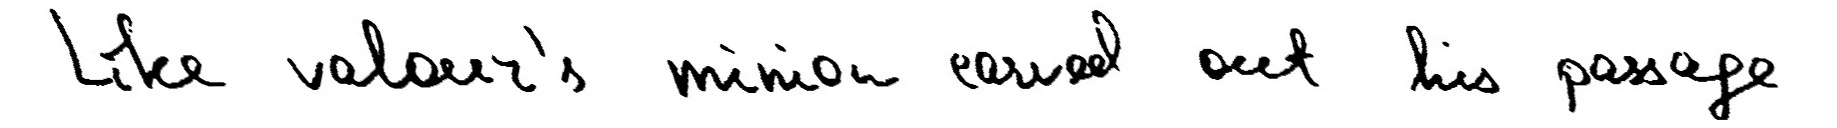

In [38]:
path = "../data/raw/test_data/"+df["image_name.jpg"][325]
show_image(path)

In [39]:
original_texts[325]

"Like valour's minion carved out his passage"

In [40]:
predicted_texts[325]

"like valover's minimum caused out his passage"

In [27]:
# Try Error Aalysis frequencies of the different types of substitutions

def calculate_wer(original_texts, predicted_texts):
    substitution_counts = {}

    for original_text, predicted_text in zip(original_texts, predicted_texts):
        original_text = str(original_text)
        predicted_text = str(predicted_text)

        ref_words = original_text.split()
        hyp_words = predicted_text.split()

        substitutions = []

        for ref, hyp in zip(ref_words, hyp_words):
            if ref != hyp:
                # Substitutions
                diff_sequence_ref = ''.join(ref_char if ref_char.lower() != hyp_char.lower() else '' for ref_char, hyp_char in zip(ref, hyp))
                diff_sequence_hyp = ''.join(hyp_char if ref_char.lower() != hyp_char.lower() else '' for ref_char, hyp_char in zip(ref, hyp))
                # substitution two letters or less only
                if len(diff_sequence_ref) > 2:
                    pass
                else:
                    substitutions.append((diff_sequence_ref, diff_sequence_hyp))
        
        # Remove empty substitutions
        substitutions = [(diff_sequence_ref, diff_sequence_hyp) for diff_sequence_ref, diff_sequence_hyp in substitutions if diff_sequence_ref != '' and diff_sequence_hyp != '']
        
        # Count the occurrences of different types of substitutions
        for substitution in substitutions:
            diff_sequence_ref, diff_sequence_hyp = substitution
            substitution_key = (diff_sequence_ref, diff_sequence_hyp)
            substitution_counts[substitution_key] = substitution_counts.get(substitution_key, 0) + 1

    return substitution_counts


wer_substitution_counts = calculate_wer(original_texts, predicted_texts)

# Print the types of substitutions and their counts
for substitution, count in wer_substitution_counts.items():
    diff_sequence_ref, diff_sequence_hyp = substitution
    print(f"Substitution: {diff_sequence_ref} -> {diff_sequence_hyp}, Count: {count}")

Substitution: et -> ll, Count: 1
Substitution: L -> d, Count: 1
Substitution: e -> a, Count: 9
Substitution: th -> ld, Count: 1
Substitution: d -> s, Count: 2
Substitution: r -> l, Count: 10
Substitution: va -> co, Count: 5
Substitution: on -> mu, Count: 8
Substitution: ca -> se, Count: 1
Substitution: o -> a, Count: 12
Substitution: x -> r, Count: 3
Substitution: v -> r, Count: 27
Substitution: r -> n, Count: 15
Substitution: or -> an, Count: 2
Substitution: n -> m, Count: 6
Substitution: ob -> at, Count: 3
Substitution: at -> of, Count: 1
Substitution: re -> vi, Count: 2
Substitution: a -> u, Count: 15
Substitution: ll -> dd, Count: 14
Substitution: a -> o, Count: 13
Substitution: re -> sa, Count: 2
Substitution: rl -> ch, Count: 1
Substitution: u -> o, Count: 2
Substitution: th -> Mr, Count: 2
Substitution: ak -> o', Count: 3
Substitution: ve -> zi, Count: 1
Substitution: g -> p, Count: 3
Substitution: x -> n, Count: 1
Substitution: or -> in, Count: 1
Substitution: in -> th, Count: 

In [28]:
def analyze_substitutions(substitution_counts):
    # Get the total count of substitutions
    total_substitutions = sum(substitution_counts.values())

    # Calculate the percentage of each substitution type
    substitution_percentages = {
        substitution: (count / total_substitutions) * 100
        for substitution, count in substitution_counts.items()
    }

    # Sort the substitution types by count in descending order
    sorted_substitutions = sorted(
        substitution_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )

    # Print the substitution types and their percentages
    print("Substitution Analysis:")
    for substitution, count in sorted_substitutions:
        diff_sequence_ref, diff_sequence_hyp = substitution
        percentage = substitution_percentages[substitution]
        print(f"Substitution: {diff_sequence_ref} -> {diff_sequence_hyp}")
        print(f"Count: {count}")
        print(f"Percentage: {percentage:.2f}%")
        print()

    if sorted_substitutions:
        # Identify the most common substitution type
        most_common_substitution = sorted_substitutions[0][0]
        print("Most Common Substitution:")
        print(f"Substitution: {most_common_substitution[0]} -> {most_common_substitution[1]}")
        print(f"Count: {substitution_counts[most_common_substitution]}")
        print(f"Percentage: {substitution_percentages[most_common_substitution]:.2f}%")
    else:
        print("No substitutions found.")

# Call the function with the substitution counts
analyze_substitutions(wer_substitution_counts)

Substitution Analysis:
Substitution: v -> r
Count: 27
Percentage: 3.84%

Substitution: r -> n
Count: 15
Percentage: 2.13%

Substitution: a -> u
Count: 15
Percentage: 2.13%

Substitution: a -> e
Count: 15
Percentage: 2.13%

Substitution: w' -> ul
Count: 15
Percentage: 2.13%

Substitution: ll -> dd
Count: 14
Percentage: 1.99%

Substitution: a -> o
Count: 13
Percentage: 1.85%

Substitution: n -> r
Count: 13
Percentage: 1.85%

Substitution: o -> a
Count: 12
Percentage: 1.70%

Substitution: r -> l
Count: 10
Percentage: 1.42%

Substitution: e -> a
Count: 9
Percentage: 1.28%

Substitution: on -> mu
Count: 8
Percentage: 1.14%

Substitution: n -> m
Count: 6
Percentage: 0.85%

Substitution: h -> b
Count: 6
Percentage: 0.85%

Substitution: my -> an
Count: 6
Percentage: 0.85%

Substitution: va -> co
Count: 5
Percentage: 0.71%

Substitution: w -> c
Count: 5
Percentage: 0.71%

Substitution: s -> r
Count: 5
Percentage: 0.71%

Substitution: us -> me
Count: 5
Percentage: 0.71%

Substitution: vl -> Lb
C

In [29]:
def analyze_substitutions(substitution_counts):
    # Get the total count of substitutions
    total_substitutions = sum(substitution_counts.values())

    # Calculate the percentage of each substitution type
    substitution_percentages = {
        substitution: count / total_substitutions * 100
        for substitution, count in substitution_counts.items()
    }

    # Sort the substitution types by count in descending order
    sorted_substitutions = sorted(
        substitution_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )

    # Identify the most common substitution type
    most_common_substitution = sorted_substitutions[0][0]
    print("Most Common Substitution:")
    print(f"Substitution: {most_common_substitution[0]} -> {most_common_substitution[1]}")
    print(f"Count: {substitution_counts[most_common_substitution]}")
    print(f"Percentage: {substitution_percentages[most_common_substitution]:.2f}%")

    # Group similar substitution types
    grouped_substitutions = {}
    for substitution, count in substitution_counts.items():
        diff_sequence_ref, diff_sequence_hyp = substitution
        group_key = diff_sequence_ref.lower()  # Group by lowercase reference
        if group_key not in grouped_substitutions:
            grouped_substitutions[group_key] = 0
        grouped_substitutions[group_key] += count

    # Sort the grouped substitution types by count in descending order
    sorted_grouped_substitutions = sorted(
        grouped_substitutions.items(),
        key=lambda x: x[1],
        reverse=True
    )

    # Print the grouped substitution types and their counts
    print("\nGrouped Substitution Analysis:")
    for group, count in sorted_grouped_substitutions:
        print(f"Group: {group}")
        print(f"Count: {count}")
        print()

    # Compare with predefined expected substitutions
    expected_substitutions = {
        ("l", "1"),
        ("o", "0"),
        ("i", "1"),
        ("v", "r"),
        ("a","u"),
        ("a","e"),        
        ("e","a"),        
        ("r","n"),
        ("ll","dd"),
        ("a","o"),
        ("w'","ul"),
        ("n","m"),
        ("h","b"),
        ("r","p"),
        ("rl","nd"),
        ("de","ob"),
        ("t","l"),
        ("t","f"),
        ("f","r"),
        ("e","s"),
        ("or","an"),
        ("re","sa"),
        ("lv","br"),
        ("w","u"),
        ("w","v"),
        ("v","u"),
        ("n","v"),
        ("h","n"),
        ("h","l"),
        ("l","b"),
        ("l","I"),
        ("n","u"),
        ("o" , "a"),
        ("n","r"),
        # Add more expected substitutions as needed
    }

    # Identify unexpected substitutions
    unexpected_substitutions = set(substitution_counts.keys()) - expected_substitutions

    # Sort the unexpected substitutions by count in descending order
    sorted_unexpected_substitutions = sorted(
        unexpected_substitutions,
        key=lambda x: substitution_counts[x],
        reverse=True
    )

    print("Unexpected Substitutions:")
    for substitution in sorted_unexpected_substitutions:
        diff_sequence_ref, diff_sequence_hyp = substitution
        count = substitution_counts[substitution]
        percentage = substitution_percentages[substitution]
        print(f"Substitution: {diff_sequence_ref} -> {diff_sequence_hyp}")
        print(f"Count: {count}")
        print(f"Percentage: {percentage:.2f}%")
        print()
        
# Call the function with the substitution counts
analyze_substitutions(wer_substitution_counts)

Most Common Substitution:
Substitution: v -> r
Count: 27
Percentage: 3.84%

Grouped Substitution Analysis:
Group: a
Count: 61

Group: r
Count: 36

Group: v
Count: 31

Group: my
Count: 28

Group: n
Count: 27

Group: s
Count: 24

Group: e
Count: 20

Group: t
Count: 18

Group: l
Count: 17

Group: o
Count: 17

Group: on
Count: 15

Group: w
Count: 15

Group: i
Count: 15

Group: w'
Count: 15

Group: ll
Count: 14

Group: of
Count: 14

Group: or
Count: 12

Group: d
Count: 11

Group: at
Count: 11

Group: h
Count: 11

Group: f
Count: 10

Group: th
Count: 9

Group: us
Count: 9

Group: m
Count: 8

Group: va
Count: 7

Group: rl
Count: 7

Group: re
Count: 6

Group: in
Count: 6

Group: ar
Count: 6

Group: an
Count: 6

Group: et
Count: 5

Group: x
Count: 5

Group: u
Count: 5

Group: lv
Count: 5

Group: vl
Count: 5

Group: yu
Count: 5

Group: ak
Count: 4

Group: oe
Count: 4

Group: to
Count: 4

Group: ru
Count: 4

Group: as
Count: 4

Group: ne
Count: 4

Group: no
Count: 4

Group: y
Count: 4

Group: qr


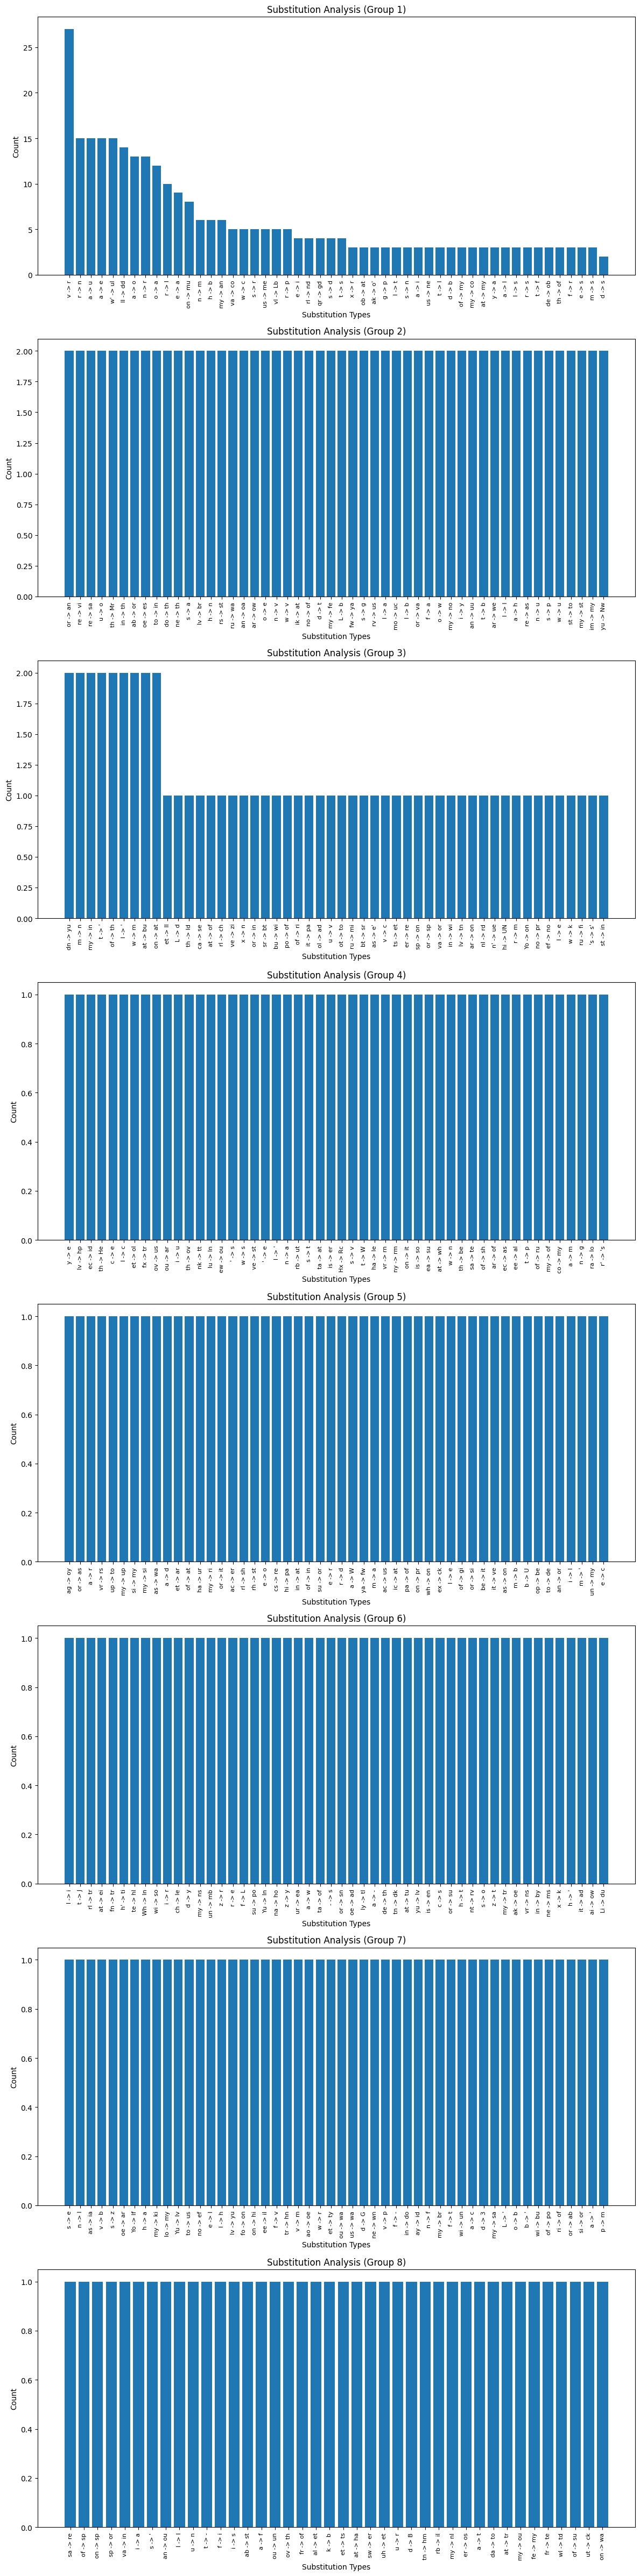

In [31]:
import matplotlib.pyplot as plt

def visualize_substitutions(substitution_counts, group_size=10):
    # Sort the substitution_counts dictionary by counts in descending order
    sorted_substitutions = sorted(
        substitution_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )

    # Extract substitution types and counts from the sorted substitutions
    substitutions = [substitution[0] for substitution in sorted_substitutions]
    counts = [substitution[1] for substitution in sorted_substitutions]

    # Split substitution types into groups
    grouped_substitutions = [substitutions[i:i+group_size] for i in range(0, len(substitutions), group_size)]
    grouped_counts = [counts[i:i+group_size] for i in range(0, len(counts), group_size)]

    # Create a bar chart for each group
    fig, axs = plt.subplots(len(grouped_substitutions), figsize=(12, 6 * len(grouped_substitutions)))

    # Customize the chart for each group
    for i, (substitutions_group, counts_group) in enumerate(zip(grouped_substitutions, grouped_counts)):
        ax = axs[i]
        ax.bar(range(len(substitutions_group)), counts_group)

        ax.set_xlabel('Substitution Types')
        ax.set_ylabel('Count')
        ax.set_title(f'Substitution Analysis (Group {i+1})')

        substitution_labels = [' -> '.join(substitution) for substitution in substitutions_group]
        ax.set_xticks(range(len(substitutions_group)))
        ax.set_xticklabels(substitution_labels, rotation='vertical', fontsize=8, ha='center')

    # Display the chart
    plt.tight_layout()
    plt.show()

# Call the function with the substitution counts
visualize_substitutions(wer_substitution_counts, group_size=50)

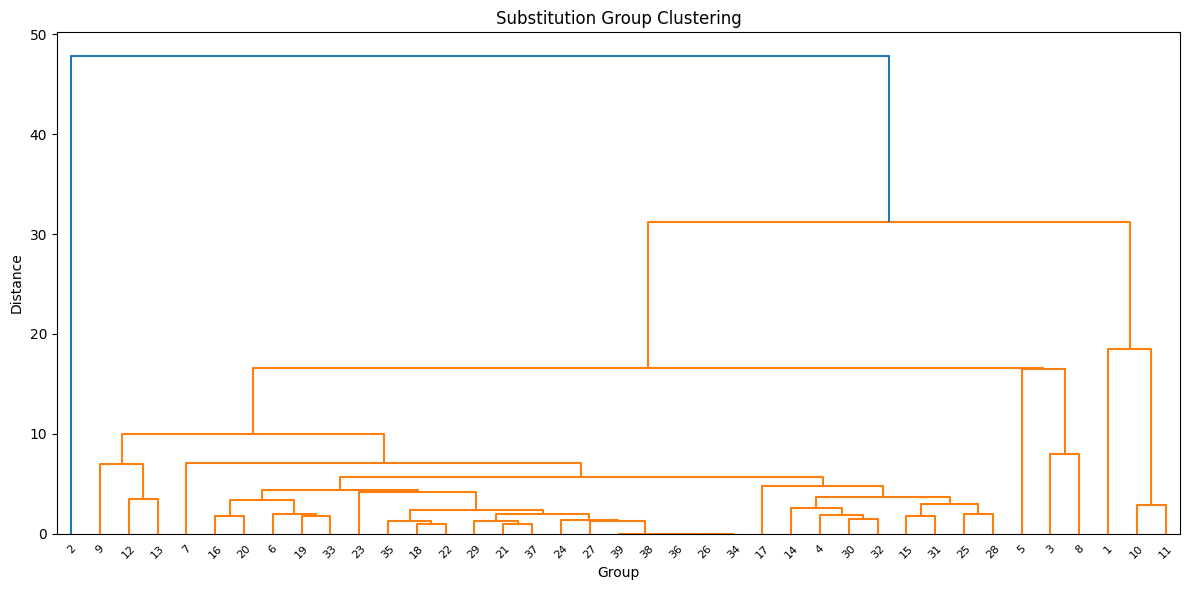

In [32]:
#observe the hierarchical relationships and similarities between the groups of substitution types.
#Clusters that are closer to each other on the dendrogram are more similar, while clusters that are farther apart are more dissimilar.

import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import numpy as np

def visualize_substitutions(substitution_counts, group_size=10):
    # Extract substitution types and counts
    substitutions = list(substitution_counts.keys())
    counts = list(substitution_counts.values())

    # Split substitution types into groups
    grouped_substitutions = [substitutions[i:i+group_size] for i in range(0, len(substitutions), group_size)]
    grouped_counts = [counts[i:i+group_size] for i in range(0, len(counts), group_size)]

    # Pad the shorter groups with zeros
    max_group_len = max(len(group) for group in grouped_counts)
    padded_counts = [group + [0] * (max_group_len - len(group)) for group in grouped_counts]

    # Convert counts to a NumPy array
    counts_array = np.array(padded_counts)

    # Calculate pairwise distances between groups
    group_distances = sch.distance.pdist(counts_array)

    # Perform hierarchical clustering
    # ward method, which minimizes the variance between the clusters.
    #The resulting linkage matrix is used to generate a dendrogram using the sch.dendrogram function.
    linkage_matrix = sch.linkage(group_distances, method='ward')

    # Plot dendrogram
    fig, ax = plt.subplots(figsize=(12, 6))
    dendrogram = sch.dendrogram(linkage_matrix, labels=range(1, len(grouped_substitutions)+1), ax=ax)

    # Customize the plot
    ax.set_xlabel('Group')
    ax.set_ylabel('Distance')
    ax.set_title('Substitution Group Clustering')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function with the substitution counts
visualize_substitutions(wer_substitution_counts, group_size=10)

In [33]:
def calculate_precision_char(original_text, predicted_text):
    # Tokenize the texts into sets of characters
    original_chars = set(original_text.lower())
    predicted_chars = set(predicted_text.lower())

    # Calculate true positives (intersection of sets)
    true_positives = len(original_chars.intersection(predicted_chars))

    # Calculate false positives
    false_positives = len(predicted_chars - original_chars)

    # Avoid division by zero
    denominator = true_positives + false_positives if true_positives + false_positives != 0 else 1

    # Calculate precision
    precision = true_positives / denominator

    return precision

def calculate_precision_list_char(original_texts, predicted_texts):
    # Ensure the input lists have the same length
    if len(original_texts) != len(predicted_texts):
        raise ValueError("Input lists must have the same length.")

    total_precision = 0.0

    for original_text, predicted_text in zip(original_texts, predicted_texts):
        # Calculate precision for the current pair of texts
        precision = calculate_precision_char(original_text, predicted_text)
        total_precision += precision

    # Calculate the average precision across all pairs
    average_precision = total_precision / len(original_texts)

    return average_precision


average_precision_char = calculate_precision_list_char(original_texts, predicted_texts)

print(f"Average Precision (Character): {average_precision_char:.2f}")


Average Precision (Character): 0.97


In [34]:
def calculate_recall_char(original_text, predicted_text):
    # Tokenize the texts into sets of characters
    original_chars = set(original_text.lower())
    predicted_chars = set(predicted_text.lower())

    # Calculate true positives (intersection of sets)
    true_positives = len(original_chars.intersection(predicted_chars))

    # Calculate false negatives
    false_negatives = len(original_chars - predicted_chars)

    # Avoid division by zero
    denominator = true_positives + false_negatives if true_positives + false_negatives != 0 else 1

    # Calculate recall
    recall = true_positives / denominator

    return recall

def calculate_recall_list_char(original_texts, predicted_texts):
    # Ensure the input lists have the same length
    if len(original_texts) != len(predicted_texts):
        raise ValueError("Input lists must have the same length.")

    total_recall = 0.0

    for original_text, predicted_text in zip(original_texts, predicted_texts):
        # Calculate recall for the current pair of texts
        recall = calculate_recall_char(original_text, predicted_text)
        total_recall += recall

    # Calculate the average recall across all pairs
    average_recall = total_recall / len(original_texts)

    return average_recall


average_recall_char = calculate_recall_list_char(original_texts, predicted_texts)

print(f"Average Recall (Character): {average_recall_char:.2f}")


Average Recall (Character): 0.98


In [35]:
def levenshtein_distance_list(original_texts, predicted_texts):
    distances = []
    error_rates = []

    for original_text, predicted_text in zip(original_texts, predicted_texts):
        m = len(original_text)
        n = len(predicted_text)

        # Initialize a matrix to store distances
        distance_matrix = [[0] * (n + 1) for _ in range(m + 1)]

        # Initialize the first row and column
        for i in range(m + 1):
            distance_matrix[i][0] = i
        for j in range(n + 1):
            distance_matrix[0][j] = j

        # Fill in the matrix
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                cost = 0 if original_text[i - 1] == predicted_text[j - 1] else 1
                distance_matrix[i][j] = min(
                    distance_matrix[i - 1][j] + 1,        # Deletion
                    distance_matrix[i][j - 1] + 1,        # Insertion
                    distance_matrix[i - 1][j - 1] + cost  # Substitution
                )

        # Calculate Levenshtein Distance
        levenshtein_distance = distance_matrix[m][n]

        # Calculate the maximum length
        max_length = max(m, n)

        # Calculate error rate percentage
        error_rate_percentage = (levenshtein_distance / max_length) * 100

        distances.append(levenshtein_distance)
        error_rates.append(error_rate_percentage)

    # Avoid division by zero
    if not distances:
        return 0.0, 0.0

    avg_distance = sum(distances) / len(distances)
    avg_error_rate = sum(error_rates) / len(error_rates)

    return avg_distance, avg_error_rate


avg_distance, avg_error_rate = levenshtein_distance_list(original_texts, predicted_texts)

print(f"Average Levenshtein Distance: {avg_distance:.2f}")
print(f"Average Error Rate: {avg_error_rate:.2f}%")


Average Levenshtein Distance: 3.24
Average Error Rate: 6.95%
